#### Mapping ATL14 and ATL15
Creates a mosaic of ATL14 tiles applying weights to each tile

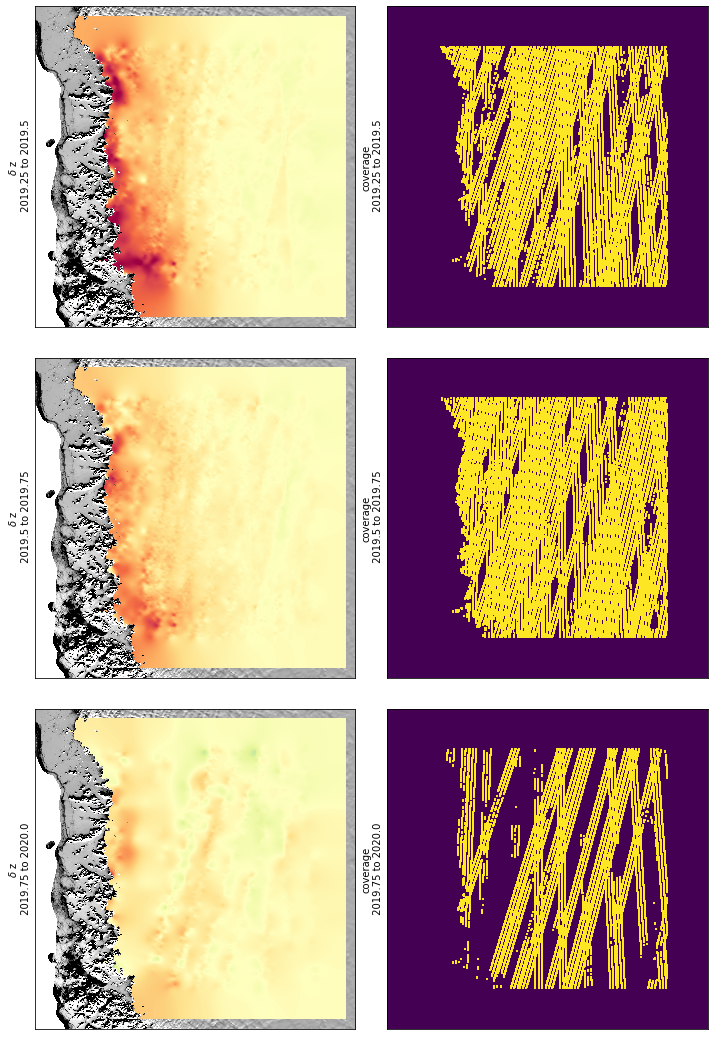

In [1]:
import glob
import re
import numpy as np
import pointCollection as pc
import matplotlib.pyplot as plt

# directory with ATL14 files
thedir = '/Volumes/ice2/ben/ATL14_test/IS2/z03xlooser_dt10xlooser_80km'

# create figure axis
fig, hax = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(11,16))

# valid range of tiles
XR=[-440000., -120000.]
YR= [-1840000., -1560000.]

# weight parameters
# pad width
W0 = 1e4
# feathering width
WF = 2e4

# add MODIS mosaic of Greenland as background
MOG=pc.grid.data().from_geotif('/Volumes/ice1/ben/MOG/2005/mog_2005_1km.tif')
for count in range(6):
    i,j = (count % 3, count//3)
    MOG.show(ax=hax[i,j], vmin=14000, vmax=17000, cmap='gray')

# find list of valid files
ctr_dict={}
file_list = []
for file in glob.glob(thedir+'/*/*.h5'):
    xc,yc=[int(item)*1.e3 for item in re.compile('E(.*)_N(.*).h5').search(file).groups()]
    if ((xc >= XR[0]) and (xc <= XR[1]) & (yc >= YR[0]) and (yc <= YR[1])): 
        file_list.append(file)
    
# get bounds, grid spacing and dimensions of output mosaic
mosaic=pc.grid.mosaic()
for file in file_list:
    # read ATL14 grid from HDF5
    temp=pc.grid.mosaic().from_h5( file, group='dz/', field_mapping={'z':'dz'})
    ctr_dict[(np.mean(temp.x), np.mean(temp.y))]=file
    # update grid spacing of output mosaic
    mosaic.update_spacing(temp)
    # update the extents of the output mosaic
    mosaic.update_bounds(temp)
    # update dimensions of output mosaic
    mosaic.update_dimensions(temp)

# create output mosaic
mosaic.data = np.zeros(mosaic.dimensions)
mosaic.mask = np.ones(mosaic.dimensions,dtype=bool)
mosaic.count = np.zeros(mosaic.dimensions)
mosaic.weight = np.zeros((mosaic.dimensions[0],mosaic.dimensions[1]))
for file in file_list:
    # read ATL14 grid from HDF5
    temp=pc.grid.mosaic().from_h5( file, group='dz/', field_mapping={'z':'dz'})
    temp=temp.weights(pad=W0, feather=WF, apply=True)
    # get the image coordinates of the input file
    iy,ix = mosaic.image_coordinates(temp)
    for band in range(mosaic.dimensions[2]):
        mosaic.data[iy,ix,band] += temp.z[:,:,band]
        mosaic.mask[iy,ix,band] = False
    # add weights to total weight matrix
    mosaic.weight[iy,ix] += temp.weight[:,:]
    # read ATL14 grid from HDF5
    temp=pc.grid.mosaic().from_h5( file, group='dz/', field_mapping={'z':'count'})
    temp=temp.weights(pad=W0, feather=WF, apply=True)
    for band in range(mosaic.dimensions[2]):
        mosaic.count[iy,ix,band] += temp.z[:,:,band]  

# find valid weights
iy,ix = np.nonzero(mosaic.weight == 0)
mosaic.mask[iy,ix,:] = True
# normalize weights
iy,ix = np.nonzero(mosaic.weight > 0)
for band in range(mosaic.dimensions[2]):
    mosaic.data[iy,ix,band] /= mosaic.weight[iy,ix]
    mosaic.count[iy,ix,band] /= mosaic.weight[iy,ix]
# replace invalid points with fill_value
mosaic.data[mosaic.mask] = mosaic.fill_value

# plot ATL14 mosaics
for count in range(0, 3):
    # show mosaic image of elevation change
    hax[count,0].imshow((mosaic.data[:,:,count+1]-mosaic.data[:,:,count]),
        extent=mosaic.extent, cmap='Spectral', vmin=-3, vmax=3, origin='lower')
    # show mosaic image of beam count
    hax[count,1].imshow((mosaic.count[:,:,count+1] > 0) & (mosaic.count[:,:,count] > 0),
        extent=mosaic.extent, vmin=0, vmax=1, origin='lower')
    # set x and y labels
    hax[count,0].set_ylabel(f'$\delta$ z\n {temp.t[count]} to {temp.t[count+1]}')
    hax[count,1].set_ylabel(f'coverage\n {temp.t[count]} to {temp.t[count+1]}')
    hax[count,1].set_yticks([])

for count in range(2):
    hax[count,0].set_xticks([])

hax[0,0].set_xlim(mosaic.extent[0:2])
hax[0,0].set_ylim(mosaic.extent[2:4])

fig.subplots_adjust(left=0.1, right=0.95, bottom=0.05, top=0.95, hspace=0.05, wspace=0.1)
plt.show()